# Тетрадка содержит код исследования количества банкоматов, которые придется ежедневно обслуживать, если в предыдущий день обслужили все, которые переполнятся через n дней или у которых через n дней окажется больше 2 недель с момента последней инкассации

Данные для моделирования 

    - величина % в годовых, которую банк платит за неинкассированную сумму денег в терминале - 2 (т.е. сумма за день = остаток * 2/100/365);
    - стоимость обслуживания одного терминала в случае его инкассирования = 0,01% от суммы инкассации, но не менее 100 рублей (т.е. для суммы 50000 = 100, для суммы 1500000 = 150);
    - максимально допустимая сумма денег в терминале - 1000000;
    - максимально допустимое время, в течение которого терминал можно не обслуживать - 14 дней;
    - стоимость одного броневика на день - 20000;
    - начало и конец рабочего дня броневиков - c 08:00 по 20:00 мск. времени;
    - время простоя броневика на точке (время на инкассирование) - 10 минут


Возьмём терминал 406136: 
На утро 01.09 остаток = 160000.

Если его обслужить 01.09 и забрать 160000, то остаток на вечер будет = 0, платить за фондирование 01.09 не надо. Но будут издержки = 100 руб. за обслуживание.
1.1. На утро 02.09 остаток станет = 90000. Добавятся 90000 из оборотов 01.09. 

Если его не обслужить 01.09, то на вечер 01.09 остаток будет = 160000 и 01.09 у вас возникают издержки, связанные с фондированием = 7.45. Издержек за обслуживание не будет.
2.1. На утро 02.09 остаток станет = 250000 (160000 + 90000 поступлений за 01.09).
	2.1.1. Если 02.09 обслужить терминал, то остаток на вечер = 0. Фондирование = 0. Издержки за обслуживание = 100.
	2.1.2. Если 02.09 не обслуживать терминал, то остаток на вечер = 250000. Фондирование = 13.70. Издержки за обслуживание = 0.


In [1]:
from typing import List

import pandas as pd
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from bank_schedule.data import Data
from bank_schedule.helpers  import calc_cartesian_coords
from bank_schedule import forecast
from bank_schedule import plot as bsplot
from bank_schedule.constants import RAW_DATA_FOLDER

In [10]:
def get_today_from_residuals(residuals: pd.DataFrame) -> pd.Timestamp:
    """Датафрейм с остатками в банкоматах

    Args:
        residuals (pd.DataFrame): _description_

    Raises:
        ValueError: _description_

    Returns:
        pd.Timestamp: _description_
    """
    today = residuals['date'].unique()
    if today.shape[0] > 1:
        raise ValueError('More than one unique date in the residuals dataframe')
    return pd.to_datetime(today[0])


def add_overflow_date(today_cash_data: pd.DataFrame,
                      forecast_model: object,
                      horizon: int=3,
                      overflow_thresh: int=10**6) -> List[int]:
    """Проставляем даты переполнения банкоматов, если оно произойдет в течение horizon дней
    1. Прогнозируем income на horizon дней вперед
    2. На основе прогноза определяем даты переполнения банкоматов в пределах заданного горизонта horizon
    3. Проставляем даты переполнения в рамках горизонта

    Args:
        today_cash_data (pd.DataFrame): данные об остатках на текущий вечер
        forecast_model (object): модель прогноза income
        horizon (int, optional): горизонт анализа. Defaults to 3.
        overflow_thresh (int, optional): порог переполнения. Defaults to 10**6.

    Raises:
        ValueError: _description_

    Returns:
        List[int]: _description_
    """
    # готовим данные
    today_cash_data = today_cash_data.copy()
    today_cash_data.set_index('TID', inplace=True)

    today = today_cash_data['date'].unique()

    if today.shape[0] > 1:
        raise ValueError('В данных об остатках дата неуникальна')

    today = today[0]
    today = pd.to_datetime(today)

    # прогнозируем income
    income_predictions = forecast_model.predict(today,
                                                n_periods=horizon,
                                                income_threshold=None)

    income_predictions.set_index('TID', inplace=True)

    # извлекаем даты, на которые делали прогноз
    predicted_dates = np.sort(income_predictions['date'].unique())

    summary_incomes = pd.Series(index=today_cash_data.index, data=0)
    overflow_date = pd.Series(index=today_cash_data.index, data=pd.NaT)
    overflow_date.name = 'overflow_date'

    overflow_cond = today_cash_data['money'] >= overflow_thresh
    overflow_date[overflow_cond] = today

    for date in predicted_dates:
        summary_incomes += income_predictions.loc[income_predictions['date'] == date,
                                                  'money_in']

        overflow_cond = today_cash_data['money'] + summary_incomes >= overflow_thresh
        overflow_cond &= overflow_date.isna()

        overflow_date[overflow_cond] = date

    today_cash_data['overflow_date'] = overflow_date

    return today_cash_data.reset_index()


def add_last_cash_collection_date(residuals: pd.DataFrame,
                                  income: pd.DataFrame) -> pd.DataFrame:
    """Считает ориентировочную дату последней инкассации
    на момент 2022-08-31 исходя из средней заполняемости банкомата в день

    Args:
        residuals (pd.DataFrame): _description_
        income (pd.DataFrame): _description_
    """

    # avg_day_income = income.groupby('TID')['money_in'].mean()

    # residuals = residuals.set_index('TID').loc[avg_day_income.index, :]
    # residuals_series = residuals['money']

    # days_from_last_collection = np.ceil(residuals_series / avg_day_income).astype(int)
    # days_from_last_collection = days_from_last_collection.apply(lambda x: min(x, 14))

    # residuals['last_collection_date'] = residuals['date'] - \
    #     pd.to_timedelta(days_from_last_collection, unit='D')
    residuals['last_collection_date'] = pd.to_datetime('2022-08-31')
    return residuals.reset_index()


def get_tids_from_list_with_proba(cash_data: pd.DataFrame,
                                  tids_list: List[int],
                                  needed_count: int,
                                  norm_scale: float=5,
                                  random_state: int=0) -> List[int]:
    """Вытаскивает из предложенных tids_list tid вероятностно опираясь
    на значение days_to_deadline

    Args:
        cash_data (pd.DataFrame): _description_
        tids_list (List[int]): _description_

    Returns:
        List[int]: _description_
    """
    norm_distr = scipy.stats.norm(0, norm_scale)
    tids_df = cash_data.loc[cash_data['TID'].isin(tids_list),
                            ['TID', 'days_to_deadline']]

    if tids_df['TID'].duplicated().any():
        raise ValueError('TID дублируются')

    other_tids = tids_df['TID'].tolist()

    other_tids_p = tids_df['days_to_deadline'].apply(norm_distr.pdf).tolist()
    p_sum = sum(other_tids_p)
    other_tids_p = [p / p_sum for p in other_tids_p]


    np.random.seed(random_state)
    needed_other_tids = np.random.choice(other_tids,
                                         size=int(needed_count),
                                         replace=False,
                                         p=other_tids_p)
    return list(needed_other_tids)


def choose_tids_to_collect(cash_data: pd.DataFrame,
                           days_to_deadline_thresh=2,
                           norm_scale: float=5,
                           max_tids: int=100,
                           random_state: int=0) -> List[int]:
    """Получает список идентификаторов банкоматов, которые нужно обслужить

    Args:
        cash_data (pd.DataFrame): _description_
        days_to_deadline_thresh (int, optional): _description_. Defaults to 2.
        norm_scale (float, optional): _description_. Defaults to 2.5.
        mandatory_rate (float, optional): _description_. Defaults to 0.7.

    Returns:
        List[int]: _description_
    """

    cond = cash_data['days_to_deadline'] <= days_to_deadline_thresh

    mandatory_tids = cash_data.loc[cond, 'TID'].unique().tolist()

    needed_other_count = max_tids - len(mandatory_tids)

    if needed_other_count <= 0:
        return mandatory_tids

    other_tids = [tid for tid in cash_data['TID'].unique() if tid not in mandatory_tids]

    needed_other_tids = get_tids_from_list_with_proba(cash_data,
                                                      other_tids,
                                                      needed_other_count,
                                                      norm_scale=norm_scale,
                                                      random_state=random_state)

    return mandatory_tids + needed_other_tids


def add_days_to_deadline(cash_data: pd.DataFrame) -> pd.DataFrame:
    """_summary_

    Args:
        cash_data (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """

    cash_data = cash_data.copy()
    days_to_collecting = 14 - (cash_data['date'] - cash_data['last_collection_date']).dt.days
    days_to_overflow_thresh = (cash_data['overflow_date'] - cash_data['date']).dt.days

    cash_data['days_to_deadline'] = list(map(min, days_to_collecting, days_to_overflow_thresh))

    return cash_data


def get_optimal_route(tids_to_collect: List[int],
                      tids_geo: pd.DataFrame,
                      distance_matrix: pd.DataFrame,
                      *args, **kwargs) -> List[int]:
    """возвращает список банкоматов, которые нужно обслужить
    в порядке оптимальног времени в пути

    Args:
        tids_to_collect (List[int]): _description_
        tids_geo (pd.DataFrame): _description_
        distance_matrix (pd.DataFrame): _description_

    Returns:
        List[int]: _description_
    """
    # тут будет оптимизатор
    route = tids_to_collect
    return route

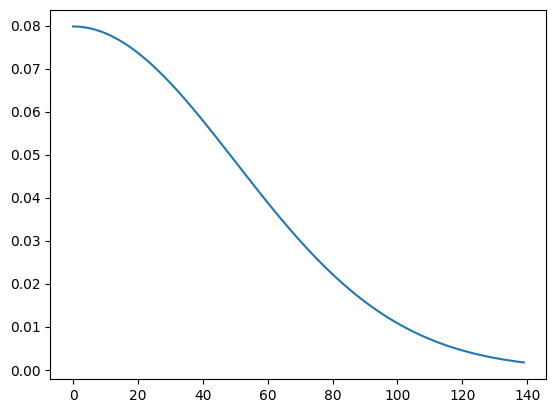

In [11]:
norm_distr = scipy.stats.norm(0, 5)
plt.plot([norm_distr.pdf(x)for x in np.arange(0, 14, .1)])
plt.show()

In [12]:
loader = Data(RAW_DATA_FOLDER)
dists = loader.get_distance_matrix()
geo = loader.get_geo_TIDS()
geo.set_index('TID', inplace=True)

income = loader.get_money_in()
residuals = loader.get_money_start()

residuals['date'] = pd.to_datetime('2022-08-31')
residuals = add_last_cash_collection_date(residuals, income)

In [13]:
display(residuals.head())

,TID,money,date,last_collection_date
0,406136,160000,2022-08-31,2022-08-29
1,406139,387000,2022-08-31,2022-08-28
2,406145,287000,2022-08-31,2022-08-28
3,406148,355000,2022-08-31,2022-08-25
4,406180,597000,2022-08-31,2022-08-23


In [14]:
hist_mdl = forecast.ForecastHistorical()
lgbm_mdl = forecast.IncomeForecastLGBM()

/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:348: UserWarning: Дата 2022-12-01 00:00:00 не найдена в исторических данных, прогнозируем средним по TID
  warn(f'Дата {next_date} не найдена в исторических данных, прогнозируем средним по TID')
/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:348: UserWarning: Дата 2022-12-01 00:00:00 не найдена в исторических данных, прогнозируем средним по TID
  warn(f'Дата {next_date} не найдена в исторических данных, прогнозируем средним по TID')
/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:348: UserWarning: Дата 2022-12-02 00:00:00 не найдена в исторических данных, прогнозируем средним по TID
  warn(f'Дата {next_date} не найдена в исторических данных, прогнозируем средним по TID')
/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:348: UserWarning: Дата 2022-12-01 00:00:00 не найдена в исторических данных, прогнозируем средним по TID
  warn(f'Д

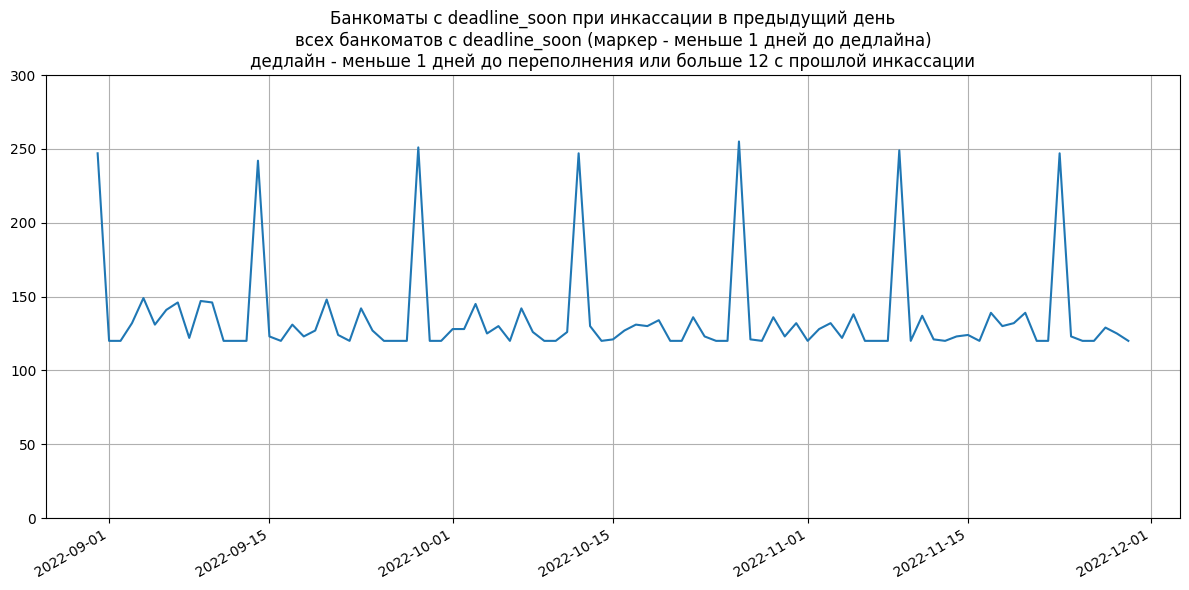

In [24]:
new_residuals = residuals.copy()
end_date = pd.to_datetime('2022-11-30')
today = get_today_from_residuals(new_residuals)

routes = []
dates = []

horizon = 14
deadline_thresh = 1

while today < end_date:
    dates.append(today)
    tomorrow = today + pd.Timedelta(days=1)

    new_residuals = add_overflow_date(new_residuals,
                                      forecast_model=hist_mdl,
                                      horizon=horizon)

    new_residuals = add_days_to_deadline(new_residuals)

    tids_to_collect = choose_tids_to_collect(new_residuals,
                                             days_to_deadline_thresh=deadline_thresh,
                                             norm_scale=50,
                                             max_tids=120)

    collected_tids = get_optimal_route(tids_to_collect, geo, dists)
    routes.append(collected_tids)

    # обнуляем остатки и дату ыв инкассированных банкоматах
    collected_cond = new_residuals['TID'].isin(collected_tids)
    new_residuals['date'] = tomorrow
    new_residuals.loc[collected_cond, 'money'] = 0
    new_residuals.loc[collected_cond, 'last_collection_date'] = tomorrow
    new_residuals.loc[collected_cond, 'overflow_date'] = pd.NaT

    # считаем остаток на вечер дня инкассации, зная income за этот день
    resid_money = new_residuals.set_index('TID')['money']
    income_money = income.set_index('TID')
    income_money = income_money.loc[income_money['date']==tomorrow, 'money_in']

    new_residuals['money'] = (resid_money + income_money).values
    today = tomorrow


collected_tids_series = pd.Series(index=dates, data=[len(r) for r in routes])

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pd.Series(data=collected_tids_series, index=dates))
plt.title('Банкоматы с deadline_soon при инкассации в предыдущий день\n'
          f'всех банкоматов с deadline_soon (маркер - меньше {deadline_thresh} дней до дедлайна)\n'
          f'дедлайн - меньше {deadline_thresh} дней до переполнения или больше {13-deadline_thresh} с прошлой инкассации')
fig.autofmt_xdate()
plt.tight_layout()
plt.ylim(0,300)
plt.grid()
plt.show()

In [28]:
# прогнозируем income
income_predictions = lgbm_mdl.predict('2022-08-31',
                                      n_periods=14,
                                      income_threshold=None)

income_predictions.set_index('TID', inplace=True)
income_predictions[income_predictions['date'] == '2022-09-01']

/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:237: UserWarning: Дата 2022-08-31 00:00:00 не найдена в данных, прогнозируем средним по TID
  warn(f'Дата {today_date} не найдена в данных, прогнозируем средним по TID')


,date,money_in
TID,,
406136,2022-09-01,92989.010989
406139,2022-09-01,153978.021978
406145,2022-09-01,131142.857143
406148,2022-09-01,67109.890110
406180,2022-09-01,75637.362637
...,...,...
699578,2022-09-01,11219.780220
699579,2022-09-01,45879.120879
699629,2022-09-01,56230.769231


In [29]:
myres = residuals.set_index('TID')

In [35]:
(myres['money'] + income_predictions[income_predictions['date'] == '2022-09-01']['money_in'] + income_predictions[income_predictions['date'] == '2022-09-02']['money_in'] > 1000000).sum()

36

<Axes: >

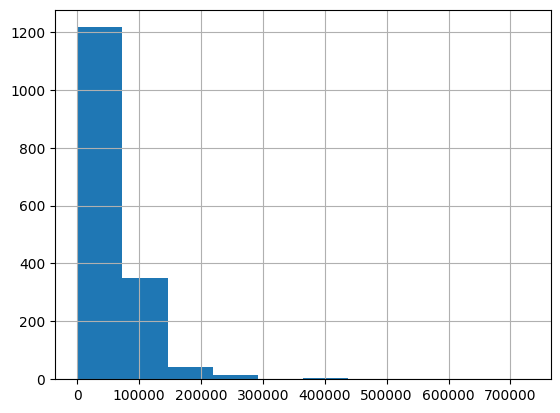

In [22]:
income[income['date']=='2022-09-01']['money_in'].hist()

In [ ]:
day = 0
geoplot_df = geo.copy()
geoplot_df['was_collected'] = geoplot_df.index.isin(routes[day])
bsplot.geoplot_clusters(geoplot_df,
                        'was_collected')

In [ ]:
def calc_min_possible_collection_time(tids_list: list,
                                      distances_matrix: pd.DataFrame,
                                      atm_service_time: int=10):
    """Считает для списка айди банкоматов минимально возможное суммарное время их объезда

    Args:
        tids_list (list): _description_
        distances_matrix (pd.DataFrame): _description_
        atm_service_time (int, optional): _description_. Defaults to 10.
    """
    cond1 = distances_matrix['Origin_tid'].index.isin(tids_list)
    cond2 = distances_matrix['Destination_tid'].index.isin(tids_list)
    filtered_matrix = distances_matrix[cond1 & cond2]
    mean_travel_time = filtered_matrix['Total_Time'].mean()
    n_points = filtered_matrix.shape[0]
    return (n_points - 1) * mean_travel_time + n_points * atm_service_time

In [ ]:
max_cars = 0
worktime = 60 * 8
for day_tids in deadline_soon_tids:
    min_time = calc_min_possible_collection_time(day_tids, dists)
    n_cars = int(np.ceil(min_time / worktime))
    if n_cars > max_cars:
        max_cars = n_cars

print(max_cars)